In [ ]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from helper import *
from code1 import *

%matplotlib inline

from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
diabetes = pd.read_csv("../Data/diabetes_data_upload.csv",header = 0)

In [40]:
diabetes.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [11]:
diabetes.shape

(520, 17)

In [12]:
diabetes.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [41]:
for i in range(2,16):
    diabetes.iloc[:,i] = diabetes.iloc[:,i].map(dict(Yes=1, No= 0))

In [45]:
diabetes.iloc[:,1]=diabetes['Gender'].map(dict(Male=0, Female=1))
diabetes.iloc[:,16]= diabetes['class'].map(dict(Positive = 1, Negative = 0))
diabetes.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [48]:
d_y_target = diabetes['class'].values
columns = diabetes.columns.tolist()
columns.remove('class')
d_x_attributes = diabetes[columns].values

In [51]:
#divide into test and training samples
d_x_train,d_x_test,d_y_train, d_y_test = train_test_split(d_x_attributes,
                                                          d_y_target, 
                                                          test_size =0.30, 
                                                          stratify = d_y_target, random_state = 1)

In [54]:
print(len(d_y_test) )
print(sum(d_y_test) )

print(len(d_y_train) )
print(sum(d_y_train) )

156
96
364
224


## Decision Tree

In [55]:
d_clf = DecisionTreeClassifier(random_state = 1)
d_clf.fit(d_x_train,d_y_train)
d_clf.get_depth() 

9

In [58]:
def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    
    auc_test = []
    auc_train = []
    max_depth = list(range(1,9))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=1, min_samples_leaf=1, criterion='gini')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
            auc_test.append(roc_auc_score(y_test, y_pred_test))
            auc_train.append(roc_auc_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

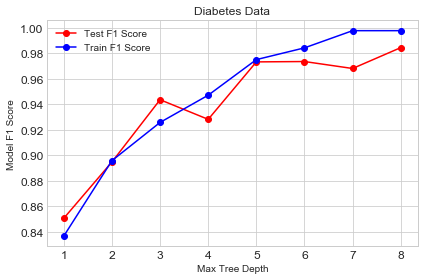

In [59]:
hyperTree(d_x_train, d_y_train, d_x_test, d_y_test, "Diabetes Data")  

In [60]:
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 10
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,10) }

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10,refit=True)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']


In [62]:
start_leaf_n = round(0.005*len(d_x_train))
end_leaf_n = round(.05*len(d_x_train))

best_depth, best_min_sample_leaf = TreeGridSearchCV(start_leaf_n,
                                                     end_leaf_n,
                                                     d_x_train,
                                                     d_y_train)


Per Hyperparameter tuning, best parameters are:
{'max_depth': 8, 'min_samples_leaf': 2}


C:\Users\Liu\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


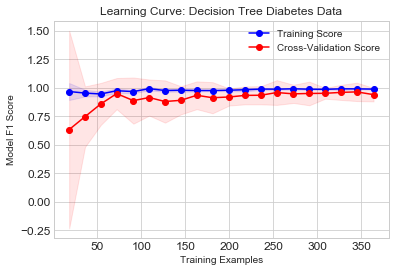

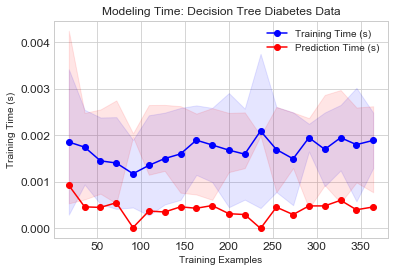

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00193
Model Prediction Time (s): 0.00028

F1 Score:  0.97
Accuracy:  0.97     AUC:       0.97
Precision: 0.98     Recall:    0.97
*****************************************************


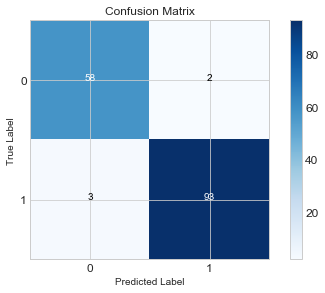

In [65]:
diabetes_credit =  DecisionTreeClassifier(random_state=1,
                                    max_depth=best_depth, 
                                    min_samples_leaf=best_min_sample_leaf, 
                                    criterion='gini')
train_samp_phish, DT_train_score_phish, DT_fit_time_phish,DT_pred_time_phish = plot_learning_curve(diabetes_credit, d_x_train, d_y_train,
                                             title="Decision Tree Diabetes Data")

final_classifier_evaluation(diabetes_credit, d_x_train, d_x_test, d_y_train, d_y_test)